In [84]:
import pandas as pd
import numpy as np
import random as rnd
import os
import datetime
import pickle

from scipy import stats
from scipy.special import boxcox1p

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm_notebook

from itertools import product

import gc

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone

import xgboost as xgb
import lightgbm as lgb

from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error,r2_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 200)

import warnings
warnings.filterwarnings('ignore')

In [85]:
from numba import jit

In [86]:
@jit
def mcc(tp, tn, fp, fn):
    sup = tp * tn - fp * fn
    inf = (tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)
    if inf==0:
        return 0
    else:
        return sup / np.sqrt(inf)



In [87]:
def eval_mcc(y_true, y_prob, show=False):
    idx = np.argsort(y_prob)
    y_true_sort = y_true[idx]
    n = y_true.shape[0]
    nump = 1.0 * np.sum(y_true) # number of positive
    numn = n - nump # number of negative
    tp = nump
    tn = 0.0
    fp = numn
    fn = 0.0
    best_mcc = 0.0
    best_id = -1
    prev_proba = -1
    best_proba = -1
    mccs = np.zeros(n)
    for i in range(n):
        # all items with idx < i are predicted negative while others are predicted positive
        # only evaluate mcc when probability changes
        proba = y_prob[idx[i]]
        if proba != prev_proba:
            prev_proba = proba
            new_mcc = mcc(tp, tn, fp, fn)
            if new_mcc >= best_mcc:
                best_mcc = new_mcc
                best_id = i
                best_proba = proba
        mccs[i] = new_mcc
        if y_true_sort[i] == 1:
            tp -= 1.0
            fn += 1.0
        else:
            fp -= 1.0
            tn += 1.0
    if show:
        y_pred = (y_prob >= best_proba).astype(int)
        score = matthews_corrcoef(y_true, y_pred)
        print(score, best_mcc)
        plt.plot(mccs)
        return best_proba, best_mcc, y_pred
    else:
        return best_mcc

In [88]:
lgb.Dataset(train, label=target).get_label()

array([0, 0, 0, ..., 0, 0, 0])

In [89]:
def mcc_eval(y_prob, dtrain):
    y_true = dtrain.get_label()
    best_mcc = eval_mcc(y_true, y_prob)
    is_higher_better = True
    return 'MCC', best_mcc, is_higher_better

In [90]:
meta_train = pd.read_csv('../input/metadata_train.csv')
meta_test = pd.read_csv('../input/metadata_test.csv')

In [91]:
numpeaks = np.load('../features/numpeaks.npy')
numpospeaks = np.load('../features/numpospeaks.npy')
numnegpeaks = np.load('../features/numnegpeaks.npy')

maxpeakwidth = np.load('../features/maxpeakwidth.npy')
minpeakwidth = np.load('../features/minpeakwidth.npy')
meanpeakwidth = np.load('../features/meanpeakwidth.npy')
maxamp = np.load('../features/maxamp.npy')
minamp = np.load('../features/minamp.npy')
meanamp = np.load('../features/meanamp.npy')

stdampall = np.load('../features/stdampall.npy')
stdposall = np.load('../features/stdposall.npy')
stdwidthall = np.load('../features/stdwidthall.npy')

stdampq2 = np.load('../features/stdampq2.npy')
stdposq2 = np.load('../features/stdposq2.npy')
stdwidthq2 = np.load('../features/stdwidthq2.npy')
stdampq3 = np.load('../features/stdampq3.npy')
stdposq3 = np.load('../features/stdposq3.npy')
stdwidthq3 = np.load('../features/stdwidthq3.npy')
stdampq4 = np.load('../features/stdampq4.npy')
stdposq4 = np.load('../features/stdposq4.npy')
stdwidthq4 = np.load('../features/stdwidthq4.npy')


In [92]:
train_features = pd.DataFrame({'NumPeaks':numpeaks, 'NumPosPeaks':numpospeaks, 'NumNegPeaks':numnegpeaks, 'MaxWidth':maxpeakwidth,
                         'MinWidth':minpeakwidth, 'MeanWidth':meanpeakwidth, 'MaxAmp':maxamp, 'MinAmp':minamp, 'MeanAmp':meanamp,
                        'StdAmpAll':stdampall, 'StdPosAll':stdposall, 'StdWidthAll':stdwidthall, 'StdAmpQ2':stdampq2, 'StdPosQ2':stdposq2,
                         'StdWidthQ2':stdwidthq2, 'StdAmpQ3':stdampq3, 'StdPosQ3':stdposq3, 'StdWidthQ3':stdwidthq3,
                        'StdAmpQ4':stdampq4, 'StdPosQ4':stdposq4, 'StdWidthQ4':stdwidthq4,})

In [93]:
train = pd.concat([meta_train, train_features], axis=1)

In [94]:
train.head()

,signal_id,id_measurement,phase,target,NumPeaks,NumPosPeaks,NumNegPeaks,MaxWidth,MinWidth,MeanWidth,MaxAmp,MinAmp,MeanAmp,StdAmpAll,StdPosAll,StdWidthAll,StdAmpQ2,StdPosQ2,StdWidthQ2,StdAmpQ3,StdPosQ3,StdWidthQ3,StdAmpQ4,StdPosQ4,StdWidthQ4
0,0,0,0,0,105,48,57,41741,1,3676.451923,46.676929,-21.931899,-0.000125,11.866878,77424.493902,7099.857490,11.214203,25011.751218,6165.933632,12.479814,22686.469829,2801.657114,8.081718,22092.125444,8984.882428
1,1,0,1,0,23,14,9,69734,1,10977.954545,13.454715,-12.666357,0.000094,8.663170,76017.661321,16116.212440,9.545417,8608.000000,0.000000,8.286657,19963.709475,6986.037612,5.719954,15027.735166,9284.827461
2,2,0,2,0,121,67,54,58988,1,3175.458333,26.176798,-30.415865,0.000112,11.285462,74713.050192,7570.433485,14.920124,24129.371090,7265.204158,11.041417,20894.197560,1152.704984,11.427326,21303.210731,5779.776683
3,3,1,0,1,217,99,118,44999,1,1820.212963,91.147620,-38.193195,0.000239,11.473998,131660.062871,4198.542517,5.535926,25928.722290,12482.994099,5.538974,22936.531117,3615.659712,5.086507,34060.095196,2594.629391
4,4,1,1,1,141,68,73,37017,1,2803.257143,14.246623,-9.247347,-0.000065,4.289404,126355.390058,5433.900865,4.720264,21722.232143,7837.139326,3.000449,25632.115546,9773.675906,3.425179,29998.890319,4142.901139


In [95]:
signal_id = train['signal_id'].values
del train['signal_id']

In [96]:
target = train['target'].values
del train['target']

In [97]:
from sklearn.metrics import matthews_corrcoef

In [98]:
skf = StratifiedKFold(n_splits=4, random_state=123, shuffle=True)

[1]	valid_0's MCC: 0.535541
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's MCC: 0.545195
[3]	valid_0's MCC: 0.545195
[4]	valid_0's MCC: 0.5445
[5]	valid_0's MCC: 0.555422
[6]	valid_0's MCC: 0.567574
[7]	valid_0's MCC: 0.562795
[8]	valid_0's MCC: 0.562877
[9]	valid_0's MCC: 0.569744
[10]	valid_0's MCC: 0.569744
[11]	valid_0's MCC: 0.574592
[12]	valid_0's MCC: 0.571352
[13]	valid_0's MCC: 0.570687
[14]	valid_0's MCC: 0.565221
[15]	valid_0's MCC: 0.574383
[16]	valid_0's MCC: 0.56399
[17]	valid_0's MCC: 0.574503
[18]	valid_0's MCC: 0.573366
[19]	valid_0's MCC: 0.569106
[20]	valid_0's MCC: 0.565847
[21]	valid_0's MCC: 0.567201
[22]	valid_0's MCC: 0.563481
[23]	valid_0's MCC: 0.564522
[24]	valid_0's MCC: 0.57141
[25]	valid_0's MCC: 0.57141
[26]	valid_0's MCC: 0.565746
[27]	valid_0's MCC: 0.563481
[28]	valid_0's MCC: 0.56399
[29]	valid_0's MCC: 0.565876
[30]	valid_0's MCC: 0.570194
[31]	valid_0's MCC: 0.575532
[32]	valid_0's MCC: 0.57732
[33]	valid_0's MCC: 0.5773

[163]	valid_0's MCC: 0.592359
[164]	valid_0's MCC: 0.592359
[165]	valid_0's MCC: 0.590097
[166]	valid_0's MCC: 0.587856
[167]	valid_0's MCC: 0.590097
[168]	valid_0's MCC: 0.590097
[169]	valid_0's MCC: 0.590097
[170]	valid_0's MCC: 0.590097
[171]	valid_0's MCC: 0.587856
[172]	valid_0's MCC: 0.587856
[173]	valid_0's MCC: 0.592359
[174]	valid_0's MCC: 0.592359
Early stopping, best iteration is:
[144]	valid_0's MCC: 0.613381
0.6133811948101966 0.6133811948101966
[1]	valid_0's MCC: 0.509432
Training until validation scores don't improve for 30 rounds.
[2]	valid_0's MCC: 0.508762
[3]	valid_0's MCC: 0.510145
[4]	valid_0's MCC: 0.507701
[5]	valid_0's MCC: 0.513537
[6]	valid_0's MCC: 0.507535
[7]	valid_0's MCC: 0.507588
[8]	valid_0's MCC: 0.512126
[9]	valid_0's MCC: 0.516763
[10]	valid_0's MCC: 0.52216
[11]	valid_0's MCC: 0.52003
[12]	valid_0's MCC: 0.526131
[13]	valid_0's MCC: 0.526364
[14]	valid_0's MCC: 0.532491
[15]	valid_0's MCC: 0.529314
[16]	valid_0's MCC: 0.532546
[17]	valid_0's MCC: 0.

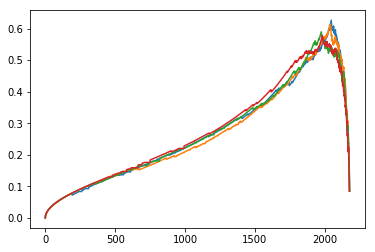

In [99]:
clf = []
val_mcc = []
val_pred = pd.DataFrame([])
proba = []
lgb_params = {
               'feature_fraction': 0.8,
               'metric': 'None',
               'nthread':8, 
               'learning_rate': 0.1, 
               'objective': 'binary', 
               'num_leaves': 2**4,
               'verbose':0, 
               'seed':123
              }


for train_idx, val_idx in skf.split(train, target):
    X_tr, y_tr = train.iloc[train_idx, :], target[train_idx]
    X_val, y_val = train.iloc[val_idx, :], target[val_idx]
 
    model_lgb = lgb.train(lgb_params, lgb.Dataset(X_tr, label=y_tr), 500,\
                           valid_sets=lgb.Dataset(X_val, label=y_val), early_stopping_rounds=30, feval=mcc_eval)
    pred_lgb = model_lgb.predict(X_val)
    
    best_proba, best_mcc, y_pred = eval_mcc(y_val, pred_lgb, show=True)
    val_mcc.append(best_mcc)
    proba.append(best_proba)
    
    pred_lgb = pd.DataFrame(pred_lgb, index=val_idx)
    val_pred = pd.concat([val_pred, pred_lgb], axis=1)
    
    clf.append(model_lgb)

In [115]:
proba

[0.24896033039573814,
 0.23200365081874583,
 0.12735655952792793,
 0.1989255263350931]

In [101]:
val_mcc

[0.626340283958949, 0.6133811948101966, 0.5897889705555547, 0.5784819706450212]

In [113]:
from sklearn.metrics import confusion_matrix

confusion_matrix(target, (np.sum(val_pred, axis=1)>np.mean(proba)).astype(int))

array([[7879,  308],
       [ 172,  353]])

0.5738188030759397 0.5738188030759397


(0.23200365081874583, 0.5738188030759397, 0       0
 1       0
 2       0
 3       0
 4       0
 5       0
 6       0
 7       0
 8       0
 9       0
 10      0
 11      0
 12      0
 13      0
 14      0
 15      0
 16      0
 17      0
 18      0
 19      0
 20      0
 21      0
 22      0
 23      0
 24      0
 25      0
 26      0
 27      0
 28      0
 29      0
 30      0
 31      0
 32      0
 33      0
 34      0
 35      0
 36      0
 37      0
 38      0
 39      0
 40      0
 41      0
 42      0
 43      0
 44      0
 45      0
 46      0
 47      0
 48      0
 49      0
 50      0
 51      0
 52      0
 53      0
 54      0
 55      0
 56      0
 57      0
 58      0
 59      0
 60      0
 61      0
 62      0
 63      0
 64      0
 65      0
 66      0
 67      0
 68      0
 69      0
 70      0
 71      0
 72      0
 73      0
 74      0
 75      0
 76      0
 77      0
 78      0
 79      0
 80      0
 81      0
 82      0
 83      0
 84      0
 85      0
 86      0
 8

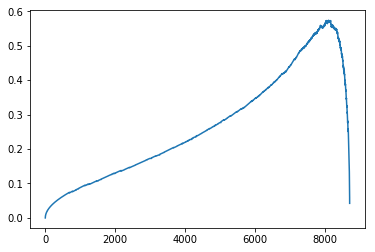

In [121]:
eval_mcc(target, np.sum(val_pred, axis=1), show=True)

In [119]:
matthews_corrcoef(target, (np.sum(val_pred, axis=1)>proba[3]).astype(int))

0.5715760828192491

In [102]:
feature_imp = np.zeros(train.shape[1])
for model in clf:
    feature_imp+=model.feature_importance(importance_type='gain')

pd.DataFrame(feature_imp/4, index=train.columns).sort_values(by=0, ascending=False)

,0
NumNegPeaks,4207.141201
MinAmp,879.821934
MaxAmp,878.654629
NumPosPeaks,700.697279
NumPeaks,567.255498
id_measurement,564.322772
StdAmpQ2,539.223046
StdAmpAll,487.487184
StdAmpQ3,454.211875
StdAmpQ4,453.505524


In [103]:
negtar = pd.concat([train['NumNegPeaks'], pd.Series(target)], axis=1)
negtar[negtar[0]==1]

,NumNegPeaks,0
3,118,1
4,73,1
5,133,1
201,98,1
202,15,1
228,0,1
229,8,1
230,50,1
270,90,1
271,16,1


In [104]:
train.iloc[2322:2346, :]

,id_measurement,phase,NumPeaks,NumPosPeaks,NumNegPeaks,MaxWidth,MinWidth,MeanWidth,MaxAmp,MinAmp,MeanAmp,StdAmpAll,StdPosAll,StdWidthAll,StdAmpQ2,StdPosQ2,StdWidthQ2,StdAmpQ3,StdPosQ3,StdWidthQ3,StdAmpQ4,StdPosQ4,StdWidthQ4
2322,774,0,0,0,0,0,0,0.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2323,774,1,1,0,1,0,0,0.000000,0.000000,-30.441270,-0.000076,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,NaN
2324,774,2,2,2,0,1,1,1.000000,19.084034,0.000000,0.000090,1.048194,0.500000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,1.048194,0.500000,0.000000
2325,775,0,16,8,8,130520,1,23989.533333,21.210753,-51.611196,-0.000155,20.695580,116842.460720,33895.500732,0.000000,0.000000,NaN,15.109178,21660.259699,13113.380835,22.042148,18901.750056,17818.383821
2326,775,1,11,9,2,106074,2,35954.700000,64.383449,-72.162144,0.000221,40.747387,131386.717630,35971.917138,0.000000,0.000000,NaN,0.000000,0.000000,NaN,20.490371,26717.511788,14073.834573
2327,775,2,39,19,20,50594,1,9141.526316,34.647800,-29.679071,-0.000059,18.841521,109997.427269,14695.650794,17.927309,31581.430885,15545.042111,19.319627,21391.966408,7919.083548,17.811874,25196.371480,13819.290148
2328,776,0,23,12,11,139127,1,17486.863636,29.719951,-31.171995,0.000023,19.785435,88319.204753,36655.465444,0.000000,0.000000,NaN,0.000000,0.000000,NaN,0.000000,0.000000,NaN
2329,776,1,1,0,1,0,0,0.000000,0.000000,-13.396848,-0.000033,0.000000,0.000000,NaN,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2330,776,2,9,3,6,16111,1,4592.500000,36.055590,-26.889329,-0.000167,24.293204,13731.811663,5656.798808,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2331,777,0,2,2,0,85,85,85.000000,20.531934,0.000000,0.000071,6.375201,42.500000,0.000000,NaN,NaN,NaN,6.375201,42.500000,0.000000,NaN,NaN,NaN


In [105]:
numpeaks = np.load('../features/numpeaks_test.npy')
numpospeaks = np.load('../features/numpospeaks_test.npy')
numnegpeaks = np.load('../features/numnegpeaks_test.npy')

maxpeakwidth = np.load('../features/maxpeakwidth_test.npy')
minpeakwidth = np.load('../features/minpeakwidth_test.npy')
meanpeakwidth = np.load('../features/meanpeakwidth_test.npy')
maxamp = np.load('../features/maxamp_test.npy')
minamp = np.load('../features/minamp_test.npy')
meanamp = np.load('../features/meanamp_test.npy')

stdampall = np.load('../features/stdampall_test.npy')
stdposall = np.load('../features/stdposall_test.npy')
stdwidthall = np.load('../features/stdwidthall_test.npy')

stdampq2 = np.load('../features/stdampq2_test.npy')
stdposq2 = np.load('../features/stdposq2_test.npy')
stdwidthq2 = np.load('../features/stdwidthq2_test.npy')
stdampq3 = np.load('../features/stdampq3_test.npy')
stdposq3 = np.load('../features/stdposq3_test.npy')
stdwidthq3 = np.load('../features/stdwidthq3_test.npy')
stdampq4 = np.load('../features/stdampq4_test.npy')
stdposq4 = np.load('../features/stdposq4_test.npy')
stdwidthq4 = np.load('../features/stdwidthq4_test.npy')


test_features = pd.DataFrame({'NumPeaks':numpeaks, 'NumPosPeaks':numpospeaks, 'NumNegPeaks':numnegpeaks, 'MaxWidth':maxpeakwidth,
                         'MinWidth':minpeakwidth, 'MeanWidth':meanpeakwidth, 'MaxAmp':maxamp, 'MinAmp':minamp, 'MeanAmp':meanamp,
                        'StdAmpAll':stdampall, 'StdPosAll':stdposall, 'StdWidthAll':stdwidthall, 'StdAmpQ2':stdampq2, 'StdPosQ2':stdposq2,
                         'StdWidthQ2':stdwidthq2, 'StdAmpQ3':stdampq3, 'StdPosQ3':stdposq3, 'StdWidthQ3':stdwidthq3,
                        'StdAmpQ4':stdampq4, 'StdPosQ4':stdposq4, 'StdWidthQ4':stdwidthq4,})

In [106]:
test = pd.concat([meta_test, test_features], axis=1)

In [107]:
test_id = test['signal_id'].values
del test['signal_id']

In [108]:
preds = None
for model in clf:
    if preds is None:
        preds = model.predict(test)
    else:
        preds += model.predict(test)
    
preds = preds/4

In [109]:
submission = pd.DataFrame({'signal_id':test_id,'target':(preds>np.mean(proba)).astype(int)})

In [110]:
submission.to_csv('../output/submission_4.csv', index=False)